In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from ipywidgets import widgets
import ConfigReader as cr

/home/mendozah/workspace/envHDMp/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [ ]:
idx = pd.IndexSlice

#Styles
sns.set_style('whitegrid', {'axes.linewidth':1.25, 'axes.edgecolor':'0.15',
                            'grid.linewidth':1.5, 'grid.color':'gray'})
sns.set_color_codes()

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 9.0)
plt.rc('text', usetex=False)
plt.rc('font', size=20.0, family='serif')

In [341]:
# Data location and scenario
experiment = 'full'
data_dir = '/mhome/mendozah/autonet_'+ experiment +'/results/experiment'
dataset = '38_bac'
preprocessor='DeepNetIterative'
plot_dir = '/mhome/mendozah/autonet_'+ experiment +'/results/plots_distributions/'

In [ ]:
fline = 'validationResults-detailed-traj-run-200-walltime.csv'
traj_file = os.path.join(data_dir, dataset, preprocessor, dataset, fline)

In [342]:
reader = cr.ConfigReader(data_dir=data_dir, dataset=dataset)
tdf = reader.load_validation_trajectories(preprocessor=preprocessor, load_config=True)

In [343]:
tdf.loc[:, ('classifier','num_layers')] = tdf['classifier']['num_layers'].apply(lambda X:ord(X)-ord('a'))

In [53]:
# Start filtering the error
temp_df = tdf.copy()
temp_df.columns = tdf.columns.droplevel(0)

In [54]:
min_perf = temp_df['test_performance'].min()
mean_perf = temp_df['test_performance'].mean()
std_perf = temp_df['test_performance'].std()
qtil_10 = temp_df['test_performance'].quantile(0.1)

In [55]:
m = tdf[('smac', 'test_performance')] <= mean_perf
#tdf[m]

### Setting values to log scale and categorical values

In [56]:
log_columns = ['beta1', 'beta2', 'gamma', 'lambda2', 'learning_rate', 'momentum','num_units_layer_1',
               'num_units_layer_2', 'num_units_layer_3', 'num_units_layer_4', 'num_units_layer_5',
               'num_units_layer_6', 'power', 'std_layer_1', 'std_layer_2', 'std_layer_3','std_layer_4',
               'std_layer_5', 'std_layer_6']

categorical_cols = ['activation_layer_1', 'activation_layer_2', 'activation_layer_3', 'activation_layer_4',
                    'activation_layer_5', 'activation_layer_6', 'lr_policy', 'num_layers', 'weight_init_1',
                    'weight_init_2', 'weight_init_3', 'weight_init_4', 'weight_init_5', 'weight_init_6']

In [57]:
for lc in log_columns:
    try:
        tdf.loc[:, ('classifier', lc)] = np.log10(tdf.loc[:, ('classifier', lc)])
    except KeyError:
        continue

In [ ]:
for cc in categorical_cols:
    try:
        tdf.loc[:, ('classifier',cc)] = tdf.loc[:, ('classifier',cc)].astype('category')
    except KeyError:
        continue

## After Setting the frames. Start with the plotting

In [344]:
# Plot the empirical CDF
sorted_train = (tdf['smac']['train_performance'].sort_values(ascending=True).values)
sorted_test  = (tdf.sort_values(by=('smac','test_performance'), ascending=True).loc[:,('smac','test_performance')].values)
ytrain = np.arange(len(sorted_train)) / float(len(sorted_train))
ytest = np.arange(len(sorted_test)) / float(len(sorted_test))

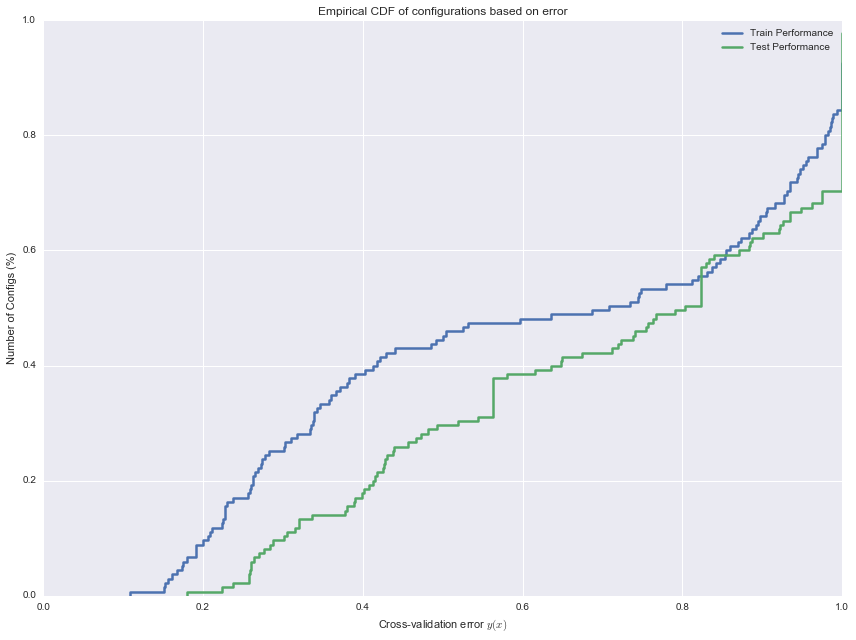

In [345]:
plt.rcParams['figure.figsize'] = (12.0, 9.0)
plt.step(sorted_train, ytrain, label="Train Performance", lw=2.5)
plt.step(sorted_test, ytest, label="Test Performance", lw=2.5)
plt.xlabel("Cross-validation error $y(x)$")
plt.ylabel(r"Number of Configs (%)")
plt.xlim(0.0, min(1.0, sorted_test.max()+.01))
plt.title("Empirical CDF of configurations based on error", fontsize=12.)
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig(plot_dir + 'CDF_Error_' + dataset)
plt.show()

In [ ]:
def plotting_threshold(error_threshold, categories):
    mask_filter = tdf[('smac','test_performance')] <= error_threshold
    filtered = tdf[mask_filter]
    fig_f, axs = plt.subplots(ncols=2,nrows=1, figsize=(15.0, 8.5))
    ax0, ax1 = axs.flat
    sns.boxplot(x=categories, y=('smac','test_performance'), data=filtered.sort_values(by=[categories]), ax=ax0)
    sns.countplot(y=categories, data=filtered.sort_values(by=[categories]), ax=ax1)
    fig_f.tight_layout()

In [ ]:
widgets.interact(plotting_threshold, error_threshold=(min_perf,mean_perf + std_perf, 0.01),
                 categories={'Solver':('classifier','solver'), 'Policy':('classifier','lr_policy'),
                             'Number of layers':('classifier','num_layers')})

### Plot distro over learning rates

In [ ]:
# Create the grouping of the filtered DF
classifier_df = tdf[m]['classifier']
solver_filt = classifier_df.groupby('solver')

In [ ]:
# Seaborns Normed Distribution plots
with sns.color_palette('Set1',7):
    for name,groups in solver_filt:
        #sns.distplot(groups.learning_rate, bins=6, kde_kws={'label':name, 'bw':0.019})
        sns.distplot(groups.learning_rate, hist=True, kde=False, bins=10,
                     hist_kws={"histtype": "step", "linewidth": 2,
                               "alpha": 0.8, "label": name}, norm_hist=False)
        #plt.hist(groups.learning_rate.values, alpha=0.6, bins=20, label=name)
    plt.legend()

In [ ]:
col_hist = sns.color_palette('Paired',8, desat=0.8)
rows_to_plot = np.int(np.ceil(len(solver_filt)/2.))
fig2, axs = plt.subplots(nrows=rows_to_plot, ncols=2, sharex=False)
fig2.suptitle('Distribution of learning rate values for each\
solver on %s \n (based on 50%% best configurations)' % dataset, y=1.02)
for ax, (name, groups) in zip(axs.flat,solver_filt):
    ax.hist(groups.learning_rate.values, histtype='bar', fill=True,
            label=name, color=col_hist.pop())
    ax.set_xlabel('learning rate (log scale) ')
    ax.set_ylabel('# of Configs')
    ax.legend()
fig2.tight_layout()
ax = axs.flat[-1]
ax.set_visible(False)

### Plot over different preprocessing methods

In [ ]:
# Create the grouping of the filtered DF
prepro_filt = tdf[m].groupby([('preprocessor','choice')])

In [ ]:
prepro_color = sns.color_palette('Paired',14, desat=0.8)

fig4, axs = plt.subplots(nrows=3, ncols=5, sharex='col', figsize=(22.,12.))
fig4.suptitle('Distribution of learning rate values for each preprocessing method')
for ax, (name, grops) in zip(axs.flat,prepro_filt):
    groups = grops['classifier']
    ax.hist(groups.learning_rate.values, bins=5, histtype='bar', fill=True, label=name,
            color=prepro_color.pop())
    ax.set_xlabel('lr values')
    ax.set_ylabel('# of Configs')
    ax.legend(loc='best')

### Plot over different solver

In [ ]:
def histogram_group_column_plotting(grouping, column):
    g = classifier_df.groupby(grouping)
    s = len(g)
    col_hist = sns.color_palette('Paired',s, desat=0.8)
    fig_hist, axs = plt.subplots(nrows=int(np.ceil(s/2.)), ncols=2, sharex='col',
                                 figsize=(15., 11.))
    for ax, (name, groups) in zip(axs.flat, g):
        ax.hist(groups[column].dropna().values, bins=15,
                histtype='bar', fill=True, label=name, alpha=0.9, color=col_hist.pop())
        ax.set_xlabel(column + ' values')
        ax.set_ylabel('# of Configs')
        ax.legend()
    ax = axs.flat[7]
    ax.set_visible(False)
    fig_hist.suptitle('Distribution of '+ column +' values for each '+(grouping))

In [ ]:
# Create columns dict
Groups = ['solver', 'lr_policy']
Plott = {'# of Epochs':'number_epochs', 'batch size':'batch_size',
         'step (lr_policy)':'epoch_step', 'Gamma':'gamma', 'Lambda':'lambda2', 'learning rate': 'learning_rate',
         'Beta 1':'beta1', 'Beta 2':'beta2', 'Momentum':'momentum', 'Rho':'rho', 'Power':'power',
         'Dropout rate of layer 1':'dropout_layer_1', 'Dropout rate of layer 2':'dropout_layer_2',
         'Dropout rate of layer 3':'dropout_layer_3', 'Dropout rate of layer 4':'dropout_layer_4',
         'Dropout rate of layer 5':'dropout_layer_5', 'Dropout rate at output':'dropout_output'}

In [ ]:
widgets.interact(histogram_group_column_plotting, grouping=Groups, column=Plott)

### Distribution of each parameter over all filtered configurations

In [ ]:
def histogram_column_plotting(column):
    #Have to convert the -1 to NaN
    fig_hist = plt.figure(6)
    ax1 = plt.subplot(111)
    ax1.set_title('Histogram of '+column)
    classifier_df[column].plot(kind='hist', bins=15, ax=ax1)
    ax1.set_xlabel('values')

In [ ]:
non_cat_cols = [item for item in classifier_df.columns.values if item not in categorical_cols]

In [ ]:
widgets.interact(histogram_column_plotting, column=non_cat_cols)

## Plot average best architectures

In [7]:
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax_arch.text(rect.get_x() + rect.get_width()/2., height + rect.get_y(),
                '%d' % int(height),
                ha='center', va='bottom')

In [364]:
def table_ax(ax):
    the_table = pd_table(ax,t, colLabels=['hyperparameters'],
                         loc='right', colWidths=[0.25, 0.25])
    return the_table

In [346]:
top5 = tdf.sort_values([('smac','test_performance')]).head(1)

In [347]:
lays = np.int(np.ceil(np.array(top5['classifier']['num_layers']).mean()))
labels_list = ['Layer_'+str(i) for i in range(1,7)]
pre_m = top5['preprocessor']['choice'].describe().top

activations = []
n_layers = []
weights = []
for i in np.arange(1,lays):
    activations.append(top5['classifier']['activation_layer_'+str(i)].describe().top)
    n_layers.append(top5['classifier']['num_units_layer_'+str(i)].mean())
    weights.append(top5['classifier']['weight_init_'+str(i)].describe().top)

In [348]:
a = pd.Series(np.array(n_layers))
botoms = np.fabs(a.sub(a.max()))/2

In [320]:
activ_list = ['relu', 'elu', 'leaky', 'sigmoid', 'tanh', 'scaledTanh', 'linear']
colr_list = sns.xkcd_palette(["windows blue", "pastel blue", "grey blue", "red orange", "emerald", "pine green", "amber"])
activation_color_codes = dict(zip(activ_list,colr_list))

In [356]:
tab = top5.classifier.T.dropna()
table_list = ['batch_size', 'dropout_output', 'learning_rate', 'lambda2', 'number_epochs', 'solver']
t = tab.loc[table_list]
t = t.append(top5['preprocessor']['choice'])

In [324]:
from pandas.tools.plotting import table as pd_table

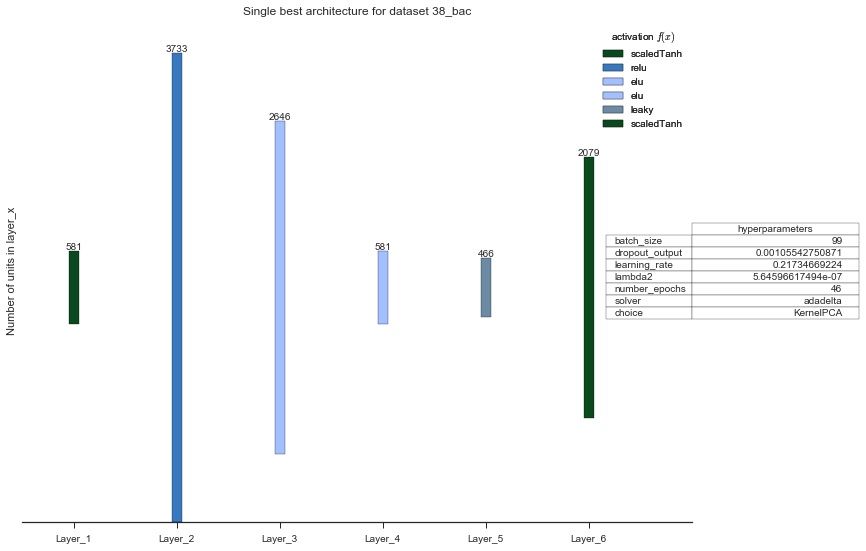

In [365]:
bar_width = 0.1
colors_bars = [activation_color_codes.get(i) for i in activations]
with sns.axes_style('ticks'):
    fig_arch = plt.figure(4, figsize=(12.,9.))
    ax_arch = plt.subplot(111)
    bars = ax_arch.bar(np.arange(lays-1)-(bar_width/2), a, bottom=botoms, width=bar_width, color=colors_bars)
    sns.despine(left=True)
    ax_arch.set_ylabel('Number of units in layer_x')
    #ax_arch.get_yaxis().set_visible(False)
    ax_arch.set_yticklabels([])
    ax_arch.set_yticks([])
    ax_arch.set_xticks(np.arange(lays-1))
    ax_arch.set_xticklabels(labels_list[:lays-1])
    autolabel(bars)
    table_ax(ax_arch)
    l0 = ax_arch.legend([b for b in bars], activations, loc='best', title='activation $f(x)$', fancybox=True)
    ax_arch.add_artist(l0)
    ax_arch.set_title('Single best architecture for dataset %s' % dataset)
    ax_arch.set_xlim(-0.5,lays - 1)

In [ ]:
colors = ["windows blue", "pastel blue", "grey blue", "red orange", "emerald", "pine green", "amber"]
sns.palplot(sns.xkcd_palette(colors))

In [ ]:
weight_list = ['he_normal', 'glorot_uniform', 'sparse', 'uniform', 'constant',
       'normal', 'glorot_normal', 'ortogonal', 'he_uniform']

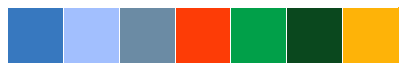

In [354]:
colr_weight_list = sns.xkcd_palette(["windows blue", "pastel blue", "grey blue", "red orange", "emerald", "pine green", "amber"])
sns.palplot(colr_weight_list)

In [ ]:
weight_color_codes = dict(zip(weight_list,colr_weight_list))